In [2]:
import pickle
import networkx as nx
import numpy as np
import random

# Load the graph
with open('Ethereum Phishing Transaction Network/MulDiGraph.pkl', 'rb') as f:
    G = pickle.load(f)
    print("Graph read successfully")

# Extract fraud and non-fraud nodes
fraud_nodes = [node for node in G.nodes if G.nodes[node]['isp'] == 1]
normal_nodes = [node for node in G.nodes if G.nodes[node]['isp'] == 0]
print(f"Fraud nodes: {len(fraud_nodes)}, Non-fraud nodes: {len(normal_nodes)}")

# Select all fraud nodes and a larger random sample of non-fraud nodes
random.seed(42)
selected_fraud = fraud_nodes
selected_normal = random.sample(normal_nodes, 10000)  # Larger sample
selected_nodes = set(selected_fraud + selected_normal)

# Expand the graph by collecting neighbors iteratively
def expand_with_neighbors(G, node_set, max_nodes=50000):
    visited = set(node_set)
    frontier = list(node_set)
    i = 0
    while len(visited) < max_nodes and i < len(frontier):
        node = frontier[i]
        neighbors = set(G.predecessors(node)) | set(G.successors(node))
        for neighbor in neighbors:
            if neighbor not in visited:
                visited.add(neighbor)
                frontier.append(neighbor)
        i += 1
    return visited

final_nodes = expand_with_neighbors(G, selected_nodes, max_nodes=50000)

# Create the subgraph
subgraph2 = G.subgraph(final_nodes).copy()
print(f"Final Subgraph - Nodes: {subgraph2.number_of_nodes()}, Edges: {subgraph2.number_of_edges()}")

Graph read successfully
Fraud nodes: 1165, Non-fraud nodes: 2972324
Final Subgraph - Nodes: 52158, Edges: 1729471


In [3]:
# Print all attributes for a specific node
node = list(subgraph2.nodes())[0]  # Pick first node
print(f"Attributes of node {node}: {subgraph2.nodes[node]}")
# Print all attributes for a specific edge
edge = list(subgraph2.edges(keys=True))[0]  # Pick first edge (u, v, key)
print(f"Attributes of edge {edge}: {subgraph2.edges[edge]}")

Attributes of node 0x5374bb21ded8a629107587e90fd2603740f4741d: {'isp': 0}
Attributes of edge ('0x5374bb21ded8a629107587e90fd2603740f4741d', '0x1c83501478f1320977047008496dacbd60bb15ef', 0): {'amount': 0.16, 'timestamp': 1516035207.0}


In [4]:
import networkx as nx

# Step 1: Assign edge weights
for u, v, key, attrs in subgraph2.edges(keys=True, data=True):
    amount = attrs.get("amount", 0)  # Default weight = 0 if amount is missing
    subgraph2[u][v][key]["weight"] = amount  # Assign weight

In [5]:
import numpy as np
import pandas as pd

node_features = {}

for node in subgraph2.nodes():
    # Compute degrees
    in_degree = subgraph2.in_degree(node)
    out_degree = subgraph2.out_degree(node)
    total_degree = in_degree + out_degree

    # Compute in-strength (sum of incoming transaction amounts)
    in_strength = sum(subgraph2[pred][node][key]["weight"] for pred in subgraph2.predecessors(node) for key in subgraph2[pred][node])
    
    # Compute out-strength (sum of outgoing transaction amounts)
    out_strength = sum(subgraph2[node][succ][key]["weight"] for succ in subgraph2.successors(node) for key in subgraph2[node][succ])
    
    # Compute total strength (total ETH transacted)
    total_strength = in_strength + out_strength

    # Compute number of unique neighbors
    unique_neighbors = len(set(subgraph2.predecessors(node)) | set(subgraph2.successors(node)))

    # Compute transaction frequency (time interval between first and last transaction)
    timestamps = []
    for succ in subgraph2.successors(node):
        for key in subgraph2[node][succ]:
            timestamps.append(subgraph2[node][succ][key]["timestamp"])
    
    txn_frequency = (max(timestamps) - min(timestamps)) / total_degree if timestamps else 0

    # Store computed features
    node_features[node] = [in_degree, out_degree, total_degree, in_strength, out_strength, total_strength, unique_neighbors, txn_frequency]

# Convert to Pandas DataFrame
df_features = pd.DataFrame.from_dict(node_features, orient='index', columns=['in_degree', 'out_degree', 'total_degree', 'in_strength', 'out_strength', 'total_strength', 'unique_neighbors', 'txn_frequency'])

In [6]:
df_features.describe()

,in_degree,out_degree,total_degree,in_strength,out_strength,total_strength,unique_neighbors,txn_frequency
count,52158.000000,52158.000000,52158.000000,5.215800e+04,5.215800e+04,5.215800e+04,52158.000000,5.215800e+04
mean,33.158307,33.158307,66.316615,2.165136e+02,2.165136e+02,4.330271e+02,14.458856,4.431634e+05
std,849.531353,711.488392,1141.596240,1.623040e+04,1.775056e+04,2.838387e+04,69.806596,1.025819e+06
min,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00
25%,0.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,2.000000e-03,1.000000,0.000000e+00
50%,1.000000,2.000000,4.000000,5.000000e-03,5.172100e-02,4.417217e-01,2.000000,4.170000e+02
75%,3.000000,8.000000,16.000000,1.454404e+00,1.053847e+00,3.963631e+00,8.000000,4.469298e+05
max,182024.000000,96526.000000,190925.000000,2.611456e+06,3.119161e+06,4.755249e+06,4348.000000,2.245649e+07


In [7]:
import numpy as np

# Check for NaN or inf in edge weights
for u, v, key, attrs in subgraph2.edges(keys=True, data=True):
    weight = attrs.get("weight", 0)
    if np.isnan(weight) or np.isinf(weight):
        print(f"Invalid weight found: {weight} for edge ({u}, {v}, {key})")

In [8]:
for u, v, key, attrs in subgraph2.edges(keys=True, data=True):
    if attrs.get("weight", 0) == 0:
        subgraph2[u][v][key]["weight"] = 1e-5  # Assign a small non-zero value

In [9]:
from torch_geometric.data import Data
import torch
# Map node IDs (addresses) to numerical indices
node_mapping = {node: i for i, node in enumerate(subgraph2.nodes())}

# Extract edges with numerical indices
edge_index = []
edge_attr = []

for u, v, key, data in subgraph2.edges(keys=True, data=True):
    edge_index.append([node_mapping[u], node_mapping[v]])  # Convert to numerical indices
    edge_attr.append([data.get("amount", 0), data.get("timestamp", 0)])  # Edge features

# Convert to PyTorch tensors
edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.long)  # Transpose for PyG format
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

# Convert node features (normalize first)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_features_normalized = pd.DataFrame(
    scaler.fit_transform(df_features), 
    index=df_features.index, 
    columns=df_features.columns
)

# Ensure the node feature order matches the numerical indices
df_features_normalized = df_features_normalized.loc[list(node_mapping.keys())]

# Convert node features to tensor
node_features_tensor = torch.tensor(df_features_normalized.values, dtype=torch.float)

# Create PyG Data object
data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr)

print(data)

Data(x=[52158, 8], edge_index=[2, 1729471], edge_attr=[1729471, 2])


In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)  # Move the entire data object to GPU

# Feature Extraction

## GCN

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import VGAE

# Define GCN Encoder for GAE
class GCNEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, embedding_dim)  # Outputs embeddings

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x  # Node embeddings
class GAE(torch.nn.Module):
    def __init__(self, encoder):
        super(GAE, self).__init__()
        self.encoder = encoder

    def decode(self, z, edge_index):
        """Inner-product decoder"""
        src, dst = edge_index
        return torch.sigmoid((z[src] * z[dst]).sum(dim=1))  # Compute similarity

    def forward(self, data):
        z = self.encoder(data.x, data.edge_index)  # Generate embeddings
        return z
def get_link_labels(pos_edge_index, neg_edge_index):
    """Creates labels: 1 for existing edges, 0 for randomly sampled negative edges"""
    pos_labels = torch.ones(pos_edge_index.size(1))
    neg_labels = torch.zeros(neg_edge_index.size(1))
    return torch.cat([pos_labels, neg_labels], dim=0)

# Negative sampling: Randomly pick node pairs that are not connected
import random

def sample_negative_edges(num_nodes, num_samples, existing_edges):
    neg_edges = set()
    while len(neg_edges) < num_samples:
        u, v = random.randint(0, num_nodes - 1), random.randint(0, num_nodes - 1)
        if (u, v) not in existing_edges and (v, u) not in existing_edges:
            neg_edges.add((u, v))
    return torch.tensor(list(neg_edges)).t()

# Prepare negative edges
num_neg_samples = data.edge_index.size(1)
neg_edge_index = sample_negative_edges(data.num_nodes, num_neg_samples, set(map(tuple, data.edge_index.t().tolist())))
# Initialize GAE model
encoder = GCNEncoder(input_dim=data.x.shape[1], hidden_dim=64, embedding_dim=128)
model = GAE(encoder).to(device)

# Optimizer & Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    z = model(data.to(device))

    pos_preds = model.decode(z, data.edge_index)
    neg_preds = model.decode(z, neg_edge_index)

    preds = torch.cat([pos_preds, neg_preds], dim=0)
    labels = get_link_labels(data.edge_index, neg_edge_index).to(device)

    loss = F.binary_cross_entropy(preds, labels)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

gcn_embeddings = model(data.to(device))
print("GCN Embeddings Shape:", gcn_embeddings.shape)

Epoch 0, Loss: 7.2153
Epoch 10, Loss: 1.6482
Epoch 20, Loss: 1.0071
Epoch 30, Loss: 0.6374
Epoch 40, Loss: 0.6582
Epoch 50, Loss: 0.5601
Epoch 60, Loss: 0.5366
Epoch 70, Loss: 0.5187
Epoch 80, Loss: 0.5283
Epoch 90, Loss: 0.6222
GCN Embeddings Shape: torch.Size([52158, 128])


## Node2Vec

In [12]:
from torch_geometric.nn import Node2Vec
import torch

# Move graph to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define Node2Vec model
node2vec = Node2Vec(
    edge_index=data.edge_index,  # Edge list
    embedding_dim=128,          # Embedding dimensionality
    walk_length=20,             # Length of random walks
    context_size=10,            # Context size for training
    walks_per_node=10,          # Number of walks per node
    num_negative_samples=1,     # Number of negative samples
    sparse=True                 # Use sparse embeddings for memory efficiency
).to(device)

# Train the model
loader = node2vec.loader(batch_size=128, shuffle=True, num_workers=4)  # Data loader
optimizer = torch.optim.SparseAdam(node2vec.parameters(), lr=0.01)           # Optimizer

def train():
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))  # Compute loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Train for multiple epochs
for epoch in range(1, 20):
    loss = train()
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}")

# Get embeddings for all nodes
node2vec_embeddings = node2vec(torch.arange(data.num_nodes, device=device))
print("Node embeddings shape:", node2vec_embeddings.shape)

Epoch: 01, Loss: 4.3797
Epoch: 02, Loss: 2.0169
Epoch: 03, Loss: 1.1864
Epoch: 04, Loss: 0.9108
Epoch: 05, Loss: 0.8163
Epoch: 06, Loss: 0.7762
Epoch: 07, Loss: 0.7559
Epoch: 08, Loss: 0.7446
Epoch: 09, Loss: 0.7375
Epoch: 10, Loss: 0.7329
Epoch: 11, Loss: 0.7297
Epoch: 12, Loss: 0.7275
Epoch: 13, Loss: 0.7259
Epoch: 14, Loss: 0.7249
Epoch: 15, Loss: 0.7243
Epoch: 16, Loss: 0.7238
Epoch: 17, Loss: 0.7238
Epoch: 18, Loss: 0.7239
Epoch: 19, Loss: 0.7242
Node embeddings shape: torch.Size([52158, 128])


## Deepwalk

In [13]:
from torch_geometric.nn import Node2Vec
import torch

# Define DeepWalk (Node2Vec with p=1, q=1)
deepwalk = Node2Vec(
    edge_index=data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    p=1.0, q=1.0,  # DeepWalk parameters
    sparse=True
).to(device)

# Train the model
loader = deepwalk.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(deepwalk.parameters(), lr=0.01)

def train():
    deepwalk.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = deepwalk.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, 20):
    loss = train()
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}")

# Extract embeddings
deepwalk_embeddings = deepwalk(torch.arange(data.num_nodes, device=device))
print("DeepWalk Embeddings Shape:", deepwalk_embeddings.shape)

Epoch: 01, Loss: 4.3931
Epoch: 02, Loss: 2.0274
Epoch: 03, Loss: 1.1926
Epoch: 04, Loss: 0.9141
Epoch: 05, Loss: 0.8182
Epoch: 06, Loss: 0.7776
Epoch: 07, Loss: 0.7570
Epoch: 08, Loss: 0.7453
Epoch: 09, Loss: 0.7381
Epoch: 10, Loss: 0.7333
Epoch: 11, Loss: 0.7302
Epoch: 12, Loss: 0.7280
Epoch: 13, Loss: 0.7263
Epoch: 14, Loss: 0.7251
Epoch: 15, Loss: 0.7244
Epoch: 16, Loss: 0.7240
Epoch: 17, Loss: 0.7238
Epoch: 18, Loss: 0.7239
Epoch: 19, Loss: 0.7241
DeepWalk Embeddings Shape: torch.Size([52158, 128])


## GraphSAGE

In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Define model and optimizer
model = GraphSAGE(in_channels=data.num_features, hidden_channels=64, out_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Unsupervised loss function (negative sampling)
def unsupervised_loss(z, pos_edge_index, neg_edge_index):
    pos_score = torch.sigmoid((z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1))
    neg_score = torch.sigmoid((z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1))
    pos_loss = -torch.log(pos_score.clamp(min=1e-10)).mean()
    neg_loss = -torch.log((1 - neg_score).clamp(min=1e-10)).mean()
    return pos_loss + neg_loss


# Train the model
def train():
    model.train()
    optimizer.zero_grad()
    
    # Generate embeddings
    z = model(data.x.to(device), data.edge_index.to(device))
    
    # Sample negative edges
    neg_edge_index = negative_sampling(
        data.edge_index, num_nodes=data.num_nodes, num_neg_samples=data.edge_index.size(1)
    ).to(device)  # Move negative samples to the same device

    # Compute unsupervised loss
    loss = unsupervised_loss(z, data.edge_index.to(device), neg_edge_index.to(device))
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    return loss.item()

# Training loop
for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")


# Extract embeddings
graphsage_embeddings = model(data.x.to(device), data.edge_index.to(device))
print("GraphSAGE Embeddings Shape:", graphsage_embeddings.shape)

Epoch 10, Loss: 8.3985
Epoch 20, Loss: 6.6329
Epoch 30, Loss: 3.4950
Epoch 40, Loss: 2.1328
Epoch 50, Loss: 1.6733
Epoch 60, Loss: 2.5516
Epoch 70, Loss: 2.4985
Epoch 80, Loss: 2.3472
Epoch 90, Loss: 2.0974
Epoch 100, Loss: 1.8646
GraphSAGE Embeddings Shape: torch.Size([52158, 128])


## VGAE

In [15]:
import torch.nn.functional as F
from torch_geometric.nn import BatchNorm

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.batch_norm = BatchNorm(2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)  
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.batch_norm(x)  # Normalize activations
        x = F.leaky_relu(x, negative_slope=0.01)
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

# Define VGAE model
model = VGAE(Encoder(in_channels=data.num_features, out_channels=128)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# Train the model
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.edge_index.to(device))
    loss = model.recon_loss(z, data.edge_index.to(device)) + 0.1 * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(1, 101):
    loss = train()
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}")

# Extract embeddings
vgae_embeddings = model.encode(data.x.to(device), data.edge_index.to(device))
print("VGAE Embeddings Shape:", vgae_embeddings.shape)

Epoch: 01, Loss: 1332310.7500
Epoch: 02, Loss: 960624.5000
Epoch: 03, Loss: 678576.3125
Epoch: 04, Loss: 476833.7812
Epoch: 05, Loss: 332785.9688
Epoch: 06, Loss: 224194.4844
Epoch: 07, Loss: 152838.7031
Epoch: 08, Loss: 94473.7812
Epoch: 09, Loss: 61530.1250
Epoch: 10, Loss: 45140.8008
Epoch: 11, Loss: 35848.5000
Epoch: 12, Loss: 29441.2070
Epoch: 13, Loss: 21697.6465
Epoch: 14, Loss: 16947.3418
Epoch: 15, Loss: 14304.5195
Epoch: 16, Loss: 12189.4766
Epoch: 17, Loss: 10718.3965
Epoch: 18, Loss: 9851.6982
Epoch: 19, Loss: 8756.0303
Epoch: 20, Loss: 8138.0068
Epoch: 21, Loss: 7069.8350
Epoch: 22, Loss: 6628.9209
Epoch: 23, Loss: 6533.6035
Epoch: 24, Loss: 5806.6104
Epoch: 25, Loss: 4893.0732
Epoch: 26, Loss: 4309.8809
Epoch: 27, Loss: 4215.8223
Epoch: 28, Loss: 4199.9111
Epoch: 29, Loss: 4196.9009
Epoch: 30, Loss: 4196.1226
Epoch: 31, Loss: 4195.7896
Epoch: 32, Loss: 4195.5542
Epoch: 33, Loss: 4195.3384
Epoch: 34, Loss: 4195.2988
Epoch: 35, Loss: 4195.4683
Epoch: 36, Loss: 4195.6362
Epo

## HOPE

In [16]:
import torch
from torch_geometric.utils import to_scipy_sparse_matrix
from scipy.sparse.linalg import svds

# Convert the edge_index to a sparse SciPy matrix (this is memory-efficient)
adj_matrix = to_scipy_sparse_matrix(data.edge_index)

# Compute Truncated SVD directly on sparse matrix
u, s, vt = svds(adj_matrix, k=128)  # k is the embedding size

# Construct the HOPE-style embedding (U * sqrt(S))
hope_embeddings = u @ torch.diag(torch.tensor(s**0.5)).numpy()

print("HOPE-style Embeddings Shape:", hope_embeddings.shape)

HOPE-style Embeddings Shape: (52158, 128)


# GAT

In [17]:
import torch
import gc

# Collect garbage
gc.collect()

# Empty PyTorch cache
torch.cuda.empty_cache()
# Optionally synchronize for safe cleanup (if you're debugging memory issues)
torch.cuda.synchronize()

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv as GATConv
from torch_geometric.nn import BatchNorm
from torch_geometric.utils import negative_sampling

class MemoryEfficientGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=64, out_channels=128, heads=4):
        super().__init__()
        # First GAT layer with reduced heads
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.4)
        self.bn1 = BatchNorm(hidden_channels * heads)
        
        # Memory-efficient intermediate layer
        self.gat2 = GATConv(hidden_channels*heads, hidden_channels, heads=2, dropout=0.4)
        self.bn2 = BatchNorm(hidden_channels*2)
        
        # Final projection without concatenation
        self.gat3 = GATConv(hidden_channels*2, out_channels, heads=1, concat=False, dropout=0.3)
        
        # Unified dropout parameters
        self.dropout = 0.4

    def forward(self, x, edge_index):
        # Layer 1 with memory cleanup
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(self.bn1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Layer 2 with memory reuse
        x = self.gat2(x, edge_index)
        x = F.elu(self.bn2(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final layer
        return self.gat3(x, edge_index)

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model with reduced parameters
model = MemoryEfficientGAT(
    in_channels=data.num_features,
    hidden_channels=64,
    out_channels=128
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

def memory_efficient_loss(z, pos_edge_index, neg_edge_index):
    # Calculate scores in chunks
    pos_scores = []
    for chunk in torch.split(pos_edge_index, 50000, dim=1):
        pos_scores.append((z[chunk[0]] * z[chunk[1]]).sum(dim=1))
    pos_scores = torch.cat(pos_scores)
    
    neg_scores = []
    for chunk in torch.split(neg_edge_index, 50000, dim=1):
        neg_scores.append((z[chunk[0]] * z[chunk[1]]).sum(dim=1))
    neg_scores = torch.cat(neg_scores)
    
    return F.binary_cross_entropy_with_logits(
        torch.cat([pos_scores, neg_scores]),
        torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)])
    )

def train():
    model.train()
    optimizer.zero_grad()
    
    # Process in smaller batches
    with torch.cuda.amp.autocast():  # Mixed precision
        z = model(data.x.to(device), data.edge_index.to(device))
        
        # Generate negatives incrementally
        neg_edge_index = negative_sampling(
            edge_index=data.edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=data.edge_index.size(1),
            method='sparse'
        ).to(device)
        
        loss = memory_efficient_loss(z, data.edge_index.to(device), neg_edge_index)
    
    # Memory cleanup
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    torch.cuda.empty_cache()
    return loss.item()

# Training loop with memory monitoring
for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}")
        if torch.cuda.is_available():
            print(f"GPU Memory: {torch.cuda.memory_allocated()/1024**2:.2f} MB")

gat_embeddings = model(data.x.to(device), data.edge_index.to(device))
print("GAT Embeddings Shape:", gat_embeddings.shape)

/tmp/ipykernel_61596/1795083389.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch 010, Loss: 1.1001
GPU Memory: 929.49 MB
Epoch 020, Loss: 1.2265
GPU Memory: 929.49 MB
Epoch 030, Loss: 0.8054
GPU Memory: 929.49 MB
Epoch 040, Loss: 0.7113
GPU Memory: 929.49 MB
Epoch 050, Loss: 0.7357
GPU Memory: 929.49 MB
Epoch 060, Loss: 0.7044
GPU Memory: 929.49 MB
Epoch 070, Loss: 0.9148
GPU Memory: 929.49 MB
Epoch 080, Loss: 0.7341
GPU Memory: 929.49 MB
Epoch 090, Loss: 0.7452
GPU Memory: 929.49 MB
Epoch 100, Loss: 0.6984
GPU Memory: 929.49 MB
GAT Embeddings Shape: torch.Size([52158, 128])


# Classification

In [19]:
# Extract fraud labels from nodes (default to 0 if missing)
y_labels = torch.tensor(
    [subgraph2.nodes[node].get("isp", 0) for node in subgraph2.nodes()],  
    dtype=torch.long  # Classification labels should be long dtype
)

# Add labels to PyG Data object
data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr, y=y_labels)
data = data.to(device)  # Move the entire data object to GPU
print(data)

Data(x=[52158, 8], edge_index=[2, 1729471], edge_attr=[1729471, 2], y=[52158])


In [20]:
print("Done!")

Done!


In [1]:

import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc

def train_lightgbm(X_final, y_final, embedding_name):
    """
    Train LightGBM using Stratified 5-Fold Cross-Validation.
    Computes Precision, Recall, F1-Score, Accuracy, PR-AUC, and ROC-AUC.
    Plots PR and ROC Curves.
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    precision_scores, recall_scores, f1_scores, accuracy_scores = [], [], [], []
    pr_auc_scores, roc_auc_scores = [], []

    all_y_true, all_y_probs = [], []

    for fold, (train_index, val_index) in enumerate(skf.split(X_final, y_final)):
        X_train, X_val = X_final[train_index], X_final[val_index]
        y_train, y_val = y_final[train_index], y_final[val_index]

        clf = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, 
                                 random_state=42, is_unbalance=True)
        clf.fit(X_train, y_train)

        y_probs = clf.predict_proba(X_val)[:, 1]  # Probability of fraud (positive) class
        y_pred = (y_probs >= 0.5).astype(int)  # Apply threshold of 0.5

        # Compute Metrics
        precision = precision_score(y_val, y_pred, average='binary')
        recall    = recall_score(y_val, y_pred, average='binary')
        f1        = f1_score(y_val, y_pred, average='binary')
        accuracy  = accuracy_score(y_val, y_pred)

        # Compute PR and ROC curves and corresponding AUC values
        precisions, recalls, _ = precision_recall_curve(y_val, y_probs)
        fpr, tpr, _ = roc_curve(y_val, y_probs)
        pr_auc = auc(recalls, precisions)
        roc_auc = auc(fpr, tpr)

        # Store Scores
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)
        pr_auc_scores.append(pr_auc)
        roc_auc_scores.append(roc_auc)

        # Collect predictions to plot consolidated curves later
        all_y_true.extend(y_val)
        all_y_probs.extend(y_probs)

        print(f"[{embedding_name}] Fold {fold+1} - PR-AUC: {pr_auc:.4f}, ROC-AUC: {roc_auc:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

    # === Final Cross-Validation Metrics ===
    print(f"\n[{embedding_name}] Final 5-Fold Metrics:")
    print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
    print(f"Recall:    {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
    print(f"F1-Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Accuracy:  {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
    print(f"PR-AUC:    {np.mean(pr_auc_scores):.4f} ± {np.std(pr_auc_scores):.4f}")
    print(f"ROC-AUC:   {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")

    # === Plot Consolidated PR & ROC Curves ===
    precisions, recalls, _ = precision_recall_curve(all_y_true, all_y_probs)
    fpr, tpr, _ = roc_curve(all_y_true, all_y_probs)

    plt.figure(figsize=(12, 5))

    # PR-AUC Plot
    plt.subplot(1, 2, 1)
    plt.plot(recalls, precisions, marker='.', label=f'Final PR-AUC = {np.mean(pr_auc_scores):.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {embedding_name}')
    plt.legend()

    # ROC-AUC Plot
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, marker='.', label=f'Final ROC-AUC = {np.mean(roc_auc_scores):.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {embedding_name}')
    plt.legend()

    plt.show()

In [21]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report, accuracy_score

def train_xgboost(X_final, y_final):
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, 
                                                            stratify=y_final, random_state=42)
    xgb_clf = xgb.XGBClassifier(
        n_estimators=200, 
        learning_rate=0.05, 
        scale_pos_weight=(sum(y_train == 0) / sum(y_train == 1)), 
        use_label_encoder=False, 
        eval_metric='logloss',
        tree_method='hist',
        device='cuda:0'
    )
    xgb_clf.fit(X_train, y_train)
    evaluate_model(xgb_clf, X_test, y_test, "XGBoost")

def train_random_forest(X_final, y_final):
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, 
                                                            stratify=y_final, random_state=42)
    rf_clf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
    rf_clf.fit(X_train, y_train)
    evaluate_model(rf_clf, X_test, y_test, "Random Forest")

def train_svm(X_final, y_final):
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, 
                                                            stratify=y_final, random_state=42)
    svm_clf = SVC(kernel="rbf", class_weight="balanced", probability=True)
    svm_clf.fit(X_train, y_train)
    evaluate_model(svm_clf, X_test, y_test, "SVM")

def evaluate_model(model, X_test, y_test, name):
    # Get prediction probabilities. Use decision_function if predict_proba not available.
    if hasattr(model, 'predict_proba'):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.decision_function(X_test)
    y_pred = (y_probs >= 0.5).astype(int)
    
    # Compute PR-AUC and ROC-AUC metrics.
    precisions, recalls, _ = precision_recall_curve(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    pr_auc = auc(recalls, precisions)
    roc_auc = auc(fpr, tpr)

    # Calculate evaluation metrics for both binary (positive class) and overall (macro)
    precision_bin = precision_score(y_test, y_pred, average='binary')
    recall_bin    = recall_score(y_test, y_pred, average='binary')
    f1_bin        = f1_score(y_test, y_pred, average='binary')

    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro    = recall_score(y_test, y_pred, average='macro')
    f1_macro        = f1_score(y_test, y_pred, average='macro')
    accuracy        = accuracy_score(y_test, y_pred)
    
    print(f"Final Test Set Evaluation - {name}:")
    print(classification_report(y_test, y_pred))
    print("Additional Metrics:")
    print(f"  Binary - Precision: {precision_bin:.4f}, Recall: {recall_bin:.4f}, F1-Score: {f1_bin:.4f}")
    print(f"  Overall (Macro) - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-Score: {f1_macro:.4f}, Accuracy: {accuracy:.4f}")
    print(f"  PR-AUC: {pr_auc:.4f}, ROC-AUC: {roc_auc:.4f}\n")
    
    plt.figure(figsize=(12, 5))
    
    # PR-AUC Curve
    plt.subplot(1, 2, 1)
    plt.plot(recalls, precisions, marker='.', label=f'PR-AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} - Precision-Recall Curve')
    plt.legend()
    
    # ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, marker='.', label=f'ROC-AUC = {roc_auc:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC Curve')
    plt.legend()
    
    plt.show()

# Example usage:
# Assuming variables like gcn_embeddings, gat_embeddings, etc., and a `data` object with .x and .y attributes are defined.


===== Training models for gcn embeddings =====
Final Feature Matrix Shape: (52158, 136)
Label Distribution: (array([0, 1]), array([50993,  1165]))
Training LightGBM on gcn embeddings...
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[gcn] Fold 1 - PR-AUC: 0.7888, ROC-AUC: 0.9797, F1-Score: 0.6328, Accuracy: 0.9785
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[gcn] Fold 2 - PR-AUC: 0.7816, ROC-AUC: 0.9749, F1-Score: 0.6312, Accuracy: 0.9794
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[gcn] Fold 3 - PR-AUC: 0.7676, ROC-AUC: 0.9739, F1-Score: 0.6321, Accuracy: 0.9796
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[gcn] Fold 4 - PR-AUC: 0.7860, ROC-AUC: 0.9743, F1-Score: 0.6582, Accuracy: 0.9819
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[gcn] Fold 5 - PR-AUC: 0.7459, ROC-AUC: 0.9624, F1-Score: 0.6091, Accuracy: 0.9779

[gcn] Final 5-Fold Metrics:
Precision: 0.5276 ± 0.0226
Recall:    0.7914 ± 0.0193
F1-Score:  0.6327 ± 0.0156
Accuracy:  0.9794 ± 0.0014
PR-AUC:    0.7740 ± 0.0158
ROC-AUC:   0.9730 ± 0.0057


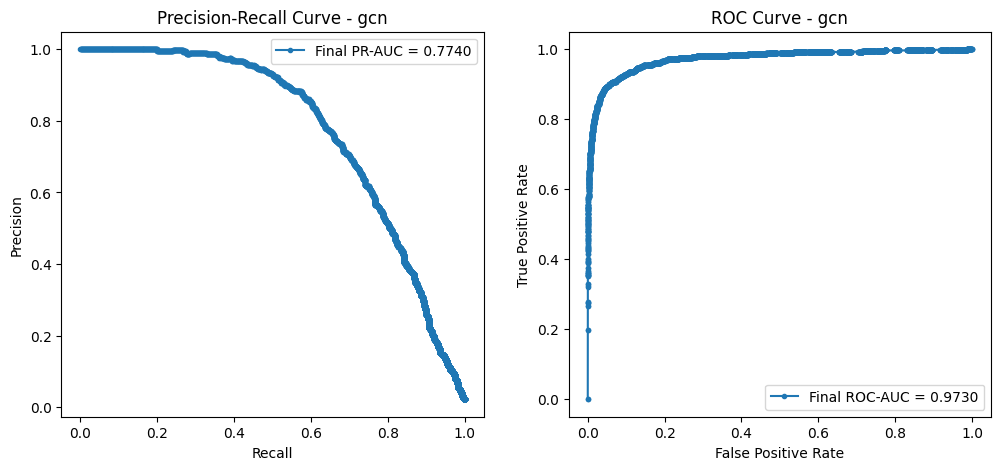

LightGBM training time for gcn embeddings: 25.86 seconds
Training XGBoost on gcn embeddings...


/home/jovyan/.mlspace/envs/dgl_exp/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:48:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jovyan/.mlspace/envs/dgl_exp/lib/python3.11/site-packages/xgboost/core.py:729: UserWarning: [15:48:09] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Final Test Set Evaluation - XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10199
           1       0.51      0.77      0.61       233

    accuracy                           0.98     10432
   macro avg       0.75      0.88      0.80     10432
weighted avg       0.98      0.98      0.98     10432

Additional Metrics:
  Binary - Precision: 0.5085, Recall: 0.7725, F1-Score: 0.6133
  Overall (Macro) - Precision: 0.7516, Recall: 0.8777, F1-Score: 0.8010, Accuracy: 0.9782
  PR-AUC: 0.7568, ROC-AUC: 0.9665



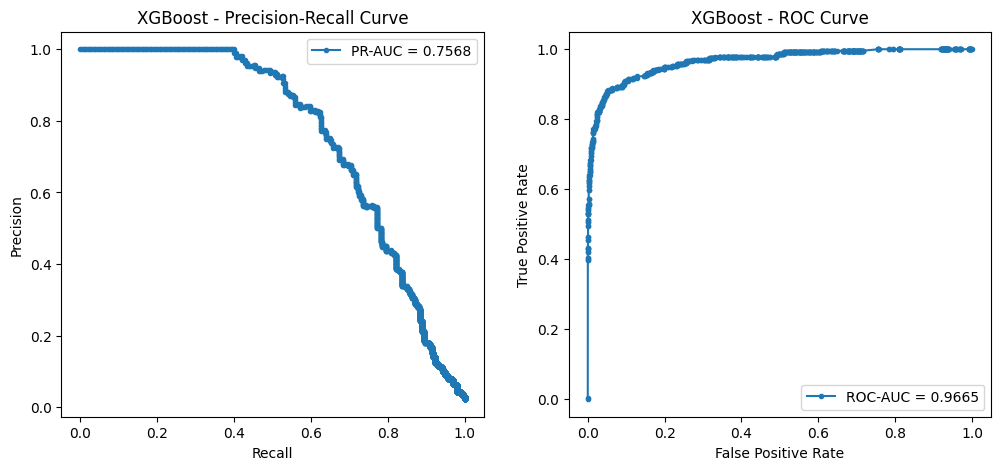

XGBoost training time for gcn embeddings: 0.98 seconds
Training Random Forest on gcn embeddings...
Final Test Set Evaluation - Random Forest:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10199
           1       0.88      0.44      0.59       233

    accuracy                           0.99     10432
   macro avg       0.93      0.72      0.79     10432
weighted avg       0.99      0.99      0.98     10432

Additional Metrics:
  Binary - Precision: 0.8803, Recall: 0.4421, F1-Score: 0.5886
  Overall (Macro) - Precision: 0.9339, Recall: 0.7203, F1-Score: 0.7908, Accuracy: 0.9862
  PR-AUC: 0.6969, ROC-AUC: 0.9394



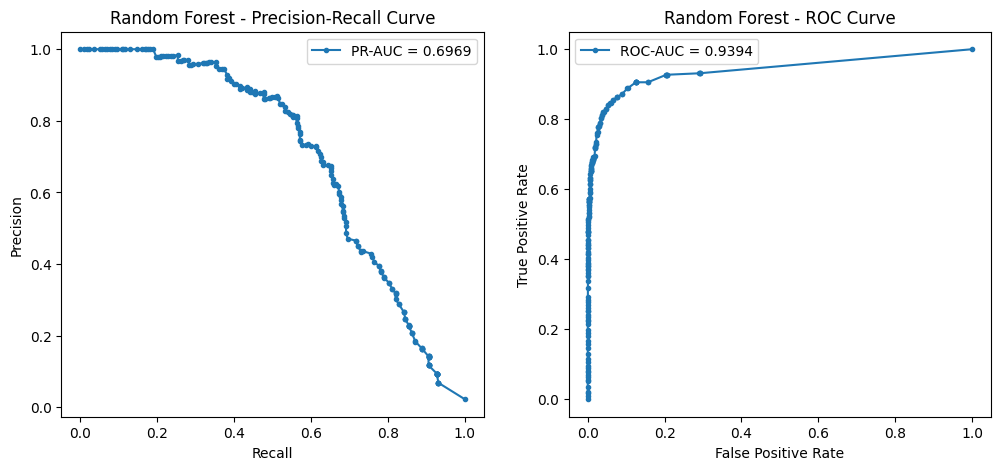

Random Forest training time for gcn embeddings: 59.85 seconds

===== Training models for gat embeddings =====
Final Feature Matrix Shape: (52158, 136)
Label Distribution: (array([0, 1]), array([50993,  1165]))
Training LightGBM on gat embeddings...
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[gat] Fold 1 - PR-AUC: 0.6818, ROC-AUC: 0.9638, F1-Score: 0.5565, Accuracy: 0.9756
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[gat] Fold 2 - PR-AUC: 0.6959, ROC-AUC: 0.9583, F1-Score: 0.5797, Accuracy: 0.9762
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[gat] Fold 3 - PR-AUC: 0.6577, ROC-AUC: 0.9501, F1-Score: 0.5371, Accuracy: 0.9749
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[gat] Fold 4 - PR-AUC: 0.6698, ROC-AUC: 0.9560, F1-Score: 0.5583, Accuracy: 0.9760
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[gat] Fold 5 - PR-AUC: 0.6485, ROC-AUC: 0.9506, F1-Score: 0.5402, Accuracy: 0.9742

[gat] Final 5-Fold Metrics:
Precision: 0.4653 ± 0.0112
Recall:    0.6858 ± 0.0267
F1-Score:  0.5544 ± 0.0152
Accuracy:  0.9754 ± 0.0007
PR-AUC:    0.6707 ± 0.0169
ROC-AUC:   0.9558 ± 0.0051


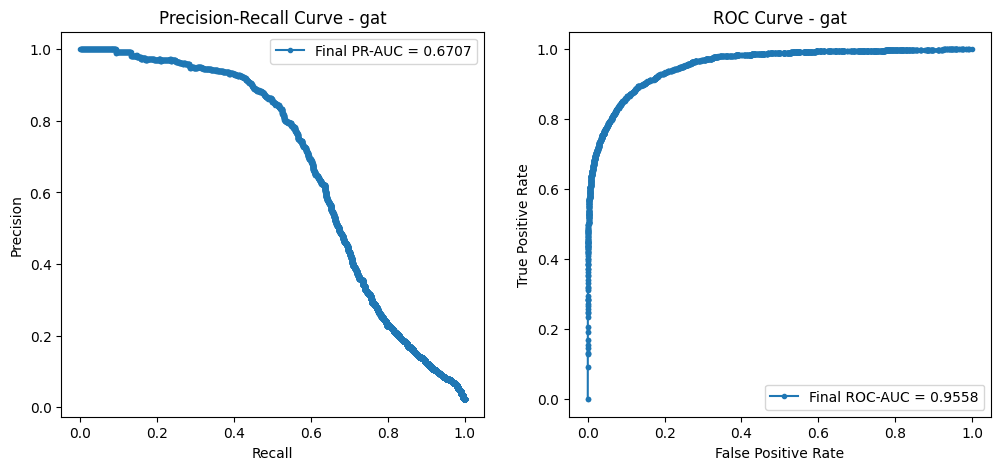

LightGBM training time for gat embeddings: 25.88 seconds
Training XGBoost on gat embeddings...


/home/jovyan/.mlspace/envs/dgl_exp/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:49:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Test Set Evaluation - XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10199
           1       0.40      0.70      0.51       233

    accuracy                           0.97     10432
   macro avg       0.70      0.84      0.75     10432
weighted avg       0.98      0.97      0.97     10432

Additional Metrics:
  Binary - Precision: 0.4035, Recall: 0.6996, F1-Score: 0.5118
  Overall (Macro) - Precision: 0.6982, Recall: 0.8380, F1-Score: 0.7482, Accuracy: 0.9702
  PR-AUC: 0.6711, ROC-AUC: 0.9579



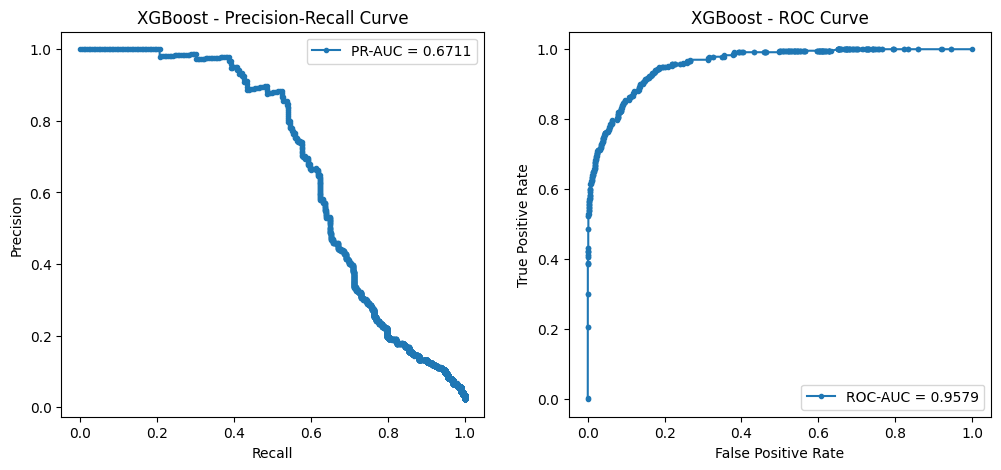

XGBoost training time for gat embeddings: 0.64 seconds
Training Random Forest on gat embeddings...
Final Test Set Evaluation - Random Forest:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10199
           1       0.87      0.33      0.48       233

    accuracy                           0.98     10432
   macro avg       0.93      0.66      0.74     10432
weighted avg       0.98      0.98      0.98     10432

Additional Metrics:
  Binary - Precision: 0.8652, Recall: 0.3305, F1-Score: 0.4783
  Overall (Macro) - Precision: 0.9250, Recall: 0.6646, F1-Score: 0.7350, Accuracy: 0.9839
  PR-AUC: 0.5796, ROC-AUC: 0.9147



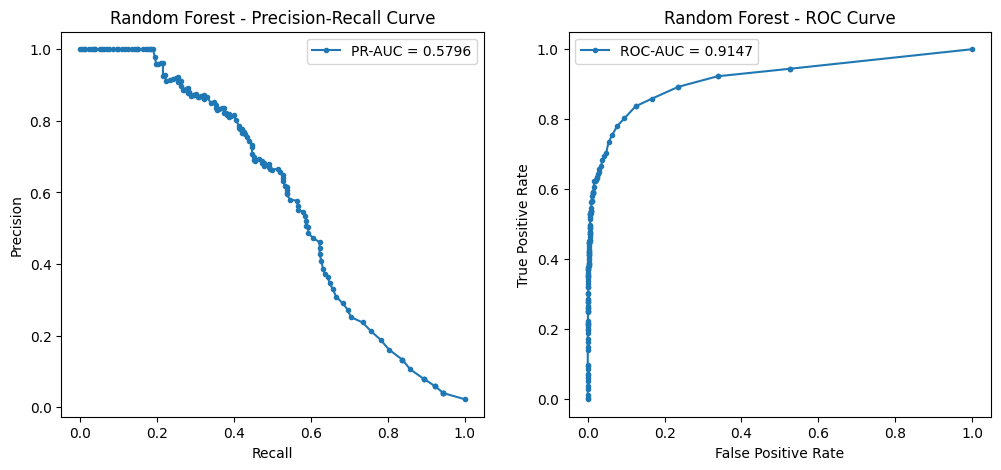

Random Forest training time for gat embeddings: 70.51 seconds

===== Training models for graphsage embeddings =====
Final Feature Matrix Shape: (52158, 136)
Label Distribution: (array([0, 1]), array([50993,  1165]))
Training LightGBM on graphsage embeddings...
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[graphsage] Fold 1 - PR-AUC: 0.7978, ROC-AUC: 0.9801, F1-Score: 0.6266, Accuracy: 0.9774
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[graphsage] Fold 2 - PR-AUC: 0.7844, ROC-AUC: 0.9759, F1-Score: 0.6091, Accuracy: 0.9761
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[graphsage] Fold 3 - PR-AUC: 0.7607, ROC-AUC: 0.9725, F1-Score: 0.5871, Accuracy: 0.9755
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[graphsage] Fold 4 - PR-AUC: 0.7954, ROC-AUC: 0.9770, F1-Score: 0.6505, Accuracy: 0.9806
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[graphsage] Fold 5 - PR-AUC: 0.7313, ROC-AUC: 0.9619, F1-Score: 0.5944, Accuracy: 0.9763

[graphsage] Final 5-Fold Metrics:
Precision: 0.4946 ± 0.0265
Recall:    0.8094 ± 0.0284
F1-Score:  0.6135 ± 0.0229
Accuracy:  0.9772 ± 0.0018
PR-AUC:    0.7739 ± 0.0251
ROC-AUC:   0.9735 ± 0.0063


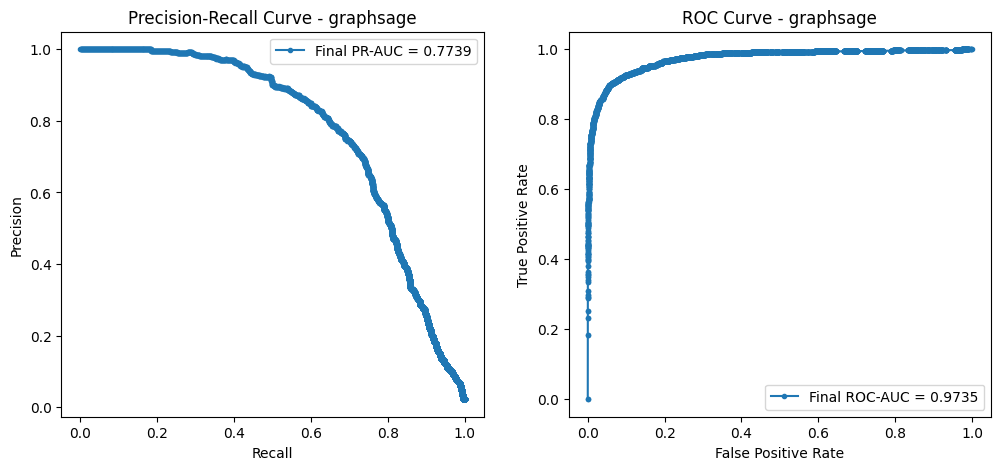

LightGBM training time for graphsage embeddings: 25.63 seconds
Training XGBoost on graphsage embeddings...


/home/jovyan/.mlspace/envs/dgl_exp/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:51:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Test Set Evaluation - XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10199
           1       0.46      0.78      0.58       233

    accuracy                           0.97     10432
   macro avg       0.73      0.88      0.78     10432
weighted avg       0.98      0.97      0.98     10432

Additional Metrics:
  Binary - Precision: 0.4641, Recall: 0.7768, F1-Score: 0.5811
  Overall (Macro) - Precision: 0.7295, Recall: 0.8782, F1-Score: 0.7841, Accuracy: 0.9750
  PR-AUC: 0.7351, ROC-AUC: 0.9637



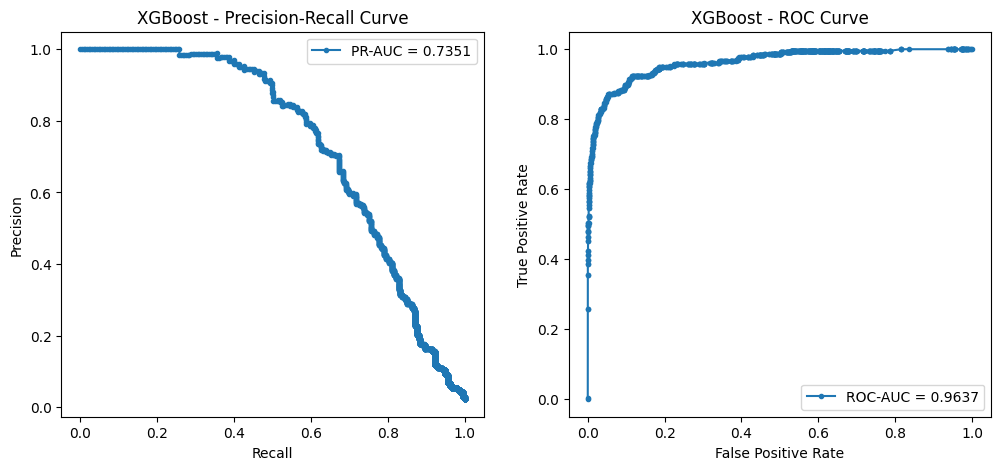

XGBoost training time for graphsage embeddings: 0.64 seconds
Training Random Forest on graphsage embeddings...
Final Test Set Evaluation - Random Forest:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10199
           1       0.82      0.43      0.57       233

    accuracy                           0.99     10432
   macro avg       0.90      0.72      0.78     10432
weighted avg       0.98      0.99      0.98     10432

Additional Metrics:
  Binary - Precision: 0.8211, Recall: 0.4335, F1-Score: 0.5674
  Overall (Macro) - Precision: 0.9042, Recall: 0.7157, F1-Score: 0.7800, Accuracy: 0.9852
  PR-AUC: 0.6446, ROC-AUC: 0.9364



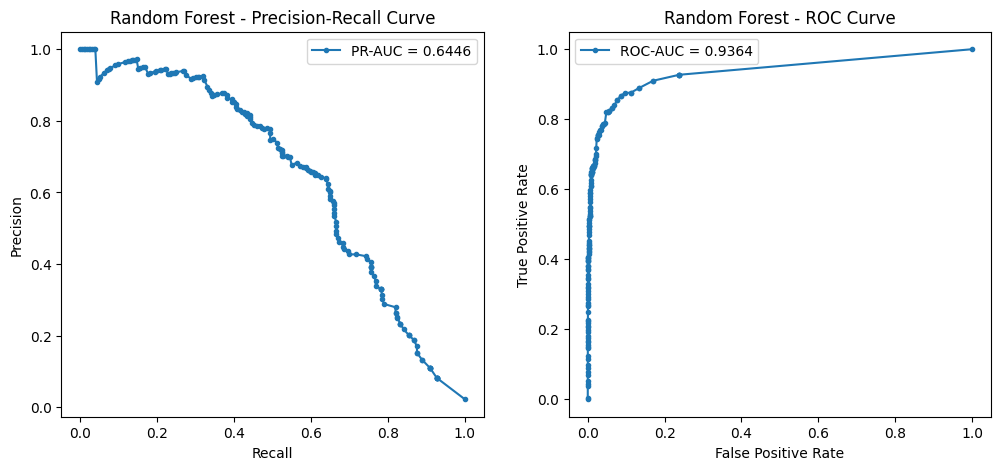

Random Forest training time for graphsage embeddings: 52.90 seconds

===== Training models for vgae embeddings =====
Final Feature Matrix Shape: (52158, 136)
Label Distribution: (array([0, 1]), array([50993,  1165]))
Training LightGBM on vgae embeddings...
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[vgae] Fold 1 - PR-AUC: 0.6727, ROC-AUC: 0.9606, F1-Score: 0.5927, Accuracy: 0.9785
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[vgae] Fold 2 - PR-AUC: 0.6843, ROC-AUC: 0.9583, F1-Score: 0.6081, Accuracy: 0.9795
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[vgae] Fold 3 - PR-AUC: 0.6235, ROC-AUC: 0.9500, F1-Score: 0.5252, Accuracy: 0.9747
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[vgae] Fold 4 - PR-AUC: 0.6685, ROC-AUC: 0.9558, F1-Score: 0.5714, Accuracy: 0.9784
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[vgae] Fold 5 - PR-AUC: 0.6430, ROC-AUC: 0.9509, F1-Score: 0.5553, Accuracy: 0.9773

[vgae] Final 5-Fold Metrics:
Precision: 0.5007 ± 0.0270
Recall:    0.6635 ± 0.0353
F1-Score:  0.5705 ± 0.0289
Accuracy:  0.9777 ± 0.0017
PR-AUC:    0.6584 ± 0.0220
ROC-AUC:   0.9551 ± 0.0041


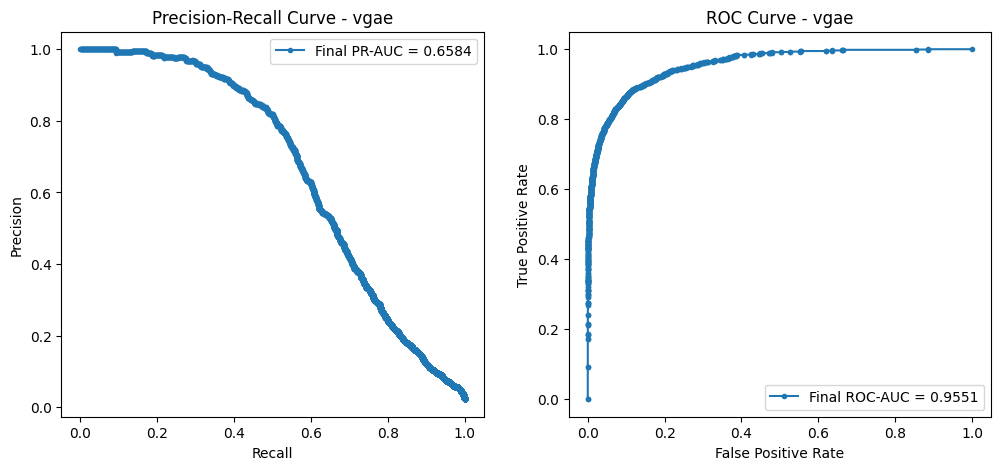

LightGBM training time for vgae embeddings: 25.86 seconds
Training XGBoost on vgae embeddings...


/home/jovyan/.mlspace/envs/dgl_exp/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:52:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Test Set Evaluation - XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10199
           1       0.41      0.70      0.52       233

    accuracy                           0.97     10432
   macro avg       0.70      0.84      0.75     10432
weighted avg       0.98      0.97      0.97     10432

Additional Metrics:
  Binary - Precision: 0.4090, Recall: 0.7039, F1-Score: 0.5174
  Overall (Macro) - Precision: 0.7010, Recall: 0.8403, F1-Score: 0.7511, Accuracy: 0.9707
  PR-AUC: 0.6601, ROC-AUC: 0.9552



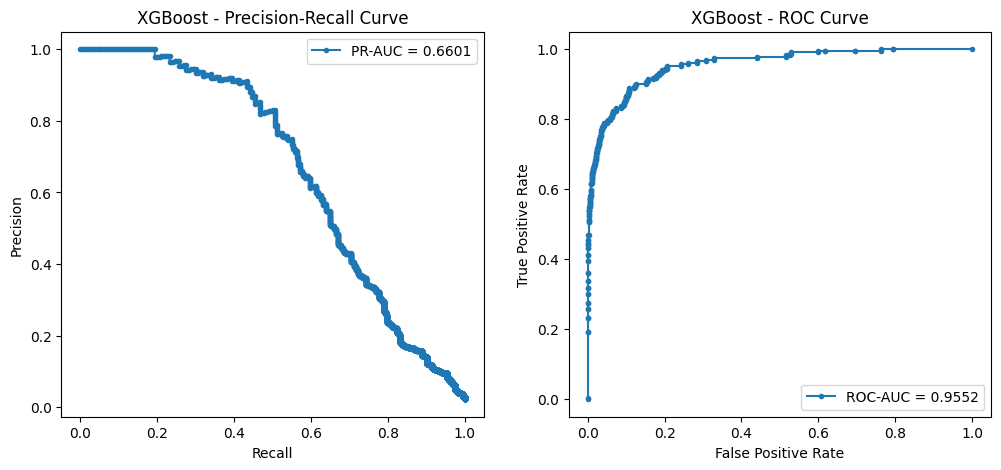

XGBoost training time for vgae embeddings: 0.62 seconds
Training Random Forest on vgae embeddings...
Final Test Set Evaluation - Random Forest:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10199
           1       0.91      0.17      0.29       233

    accuracy                           0.98     10432
   macro avg       0.95      0.59      0.64     10432
weighted avg       0.98      0.98      0.97     10432

Additional Metrics:
  Binary - Precision: 0.9091, Recall: 0.1717, F1-Score: 0.2888
  Overall (Macro) - Precision: 0.9453, Recall: 0.5856, F1-Score: 0.6396, Accuracy: 0.9811
  PR-AUC: 0.5555, ROC-AUC: 0.9251



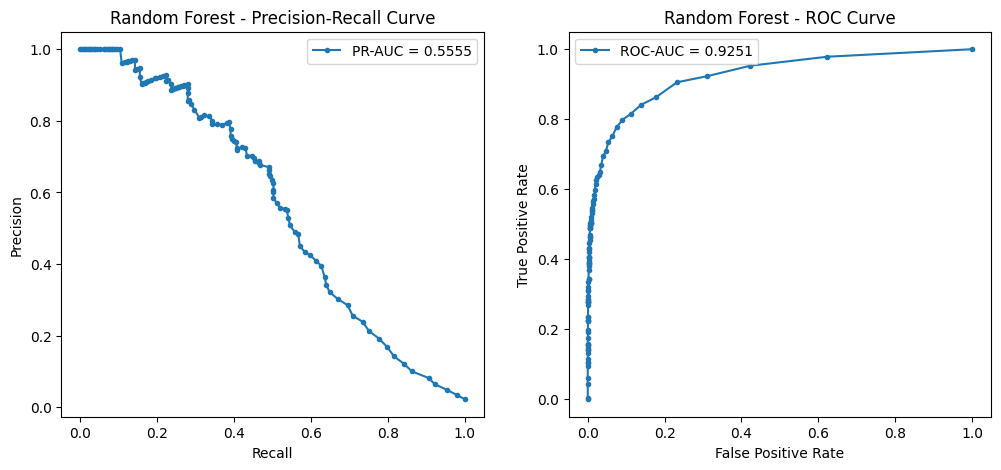

Random Forest training time for vgae embeddings: 89.71 seconds

===== Training models for node2vec embeddings =====
Final Feature Matrix Shape: (52158, 136)
Label Distribution: (array([0, 1]), array([50993,  1165]))
Training LightGBM on node2vec embeddings...
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[node2vec] Fold 1 - PR-AUC: 0.6900, ROC-AUC: 0.9615, F1-Score: 0.6212, Accuracy: 0.9819
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[node2vec] Fold 2 - PR-AUC: 0.7150, ROC-AUC: 0.9718, F1-Score: 0.6528, Accuracy: 0.9825
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[node2vec] Fold 3 - PR-AUC: 0.6759, ROC-AUC: 0.9570, F1-Score: 0.6019, Accuracy: 0.9803
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[node2vec] Fold 4 - PR-AUC: 0.7360, ROC-AUC: 0.9665, F1-Score: 0.6614, Accuracy: 0.9836
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[node2vec] Fold 5 - PR-AUC: 0.6698, ROC-AUC: 0.9636, F1-Score: 0.5961, Accuracy: 0.9803

[node2vec] Final 5-Fold Metrics:
Precision: 0.5760 ± 0.0245
Recall:    0.6876 ± 0.0336
F1-Score:  0.6267 ± 0.0263
Accuracy:  0.9817 ± 0.0013
PR-AUC:    0.6974 ± 0.0248
ROC-AUC:   0.9641 ± 0.0049


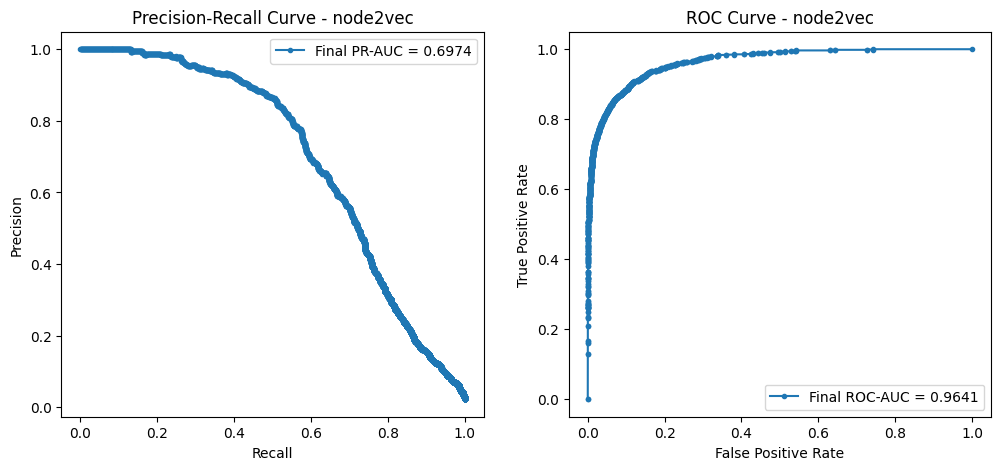

LightGBM training time for node2vec embeddings: 25.95 seconds
Training XGBoost on node2vec embeddings...


/home/jovyan/.mlspace/envs/dgl_exp/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:54:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Test Set Evaluation - XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10199
           1       0.55      0.68      0.61       233

    accuracy                           0.98     10432
   macro avg       0.77      0.83      0.80     10432
weighted avg       0.98      0.98      0.98     10432

Additional Metrics:
  Binary - Precision: 0.5464, Recall: 0.6824, F1-Score: 0.6069
  Overall (Macro) - Precision: 0.7695, Recall: 0.8347, F1-Score: 0.7984, Accuracy: 0.9803
  PR-AUC: 0.6859, ROC-AUC: 0.9542



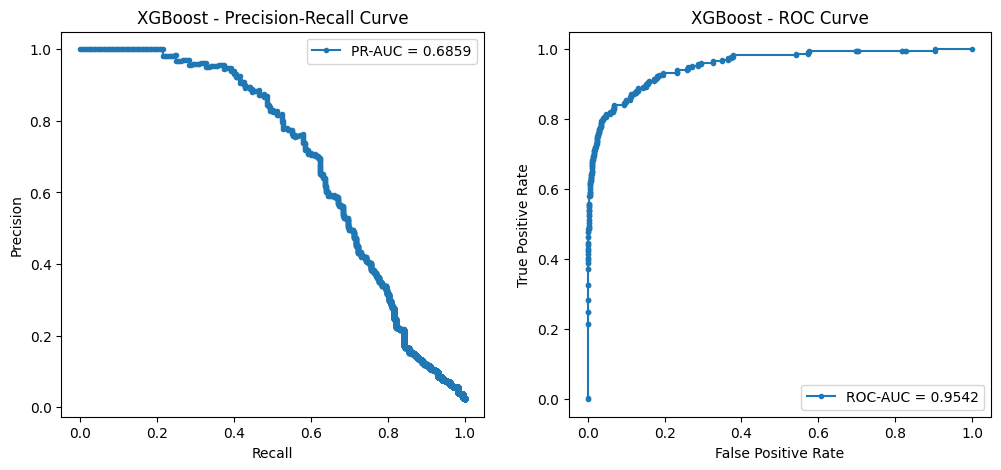

XGBoost training time for node2vec embeddings: 0.65 seconds
Training Random Forest on node2vec embeddings...
Final Test Set Evaluation - Random Forest:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10199
           1       1.00      0.01      0.02       233

    accuracy                           0.98     10432
   macro avg       0.99      0.50      0.50     10432
weighted avg       0.98      0.98      0.97     10432

Additional Metrics:
  Binary - Precision: 1.0000, Recall: 0.0086, F1-Score: 0.0170
  Overall (Macro) - Precision: 0.9889, Recall: 0.5043, F1-Score: 0.5029, Accuracy: 0.9779
  PR-AUC: 0.4323, ROC-AUC: 0.9196



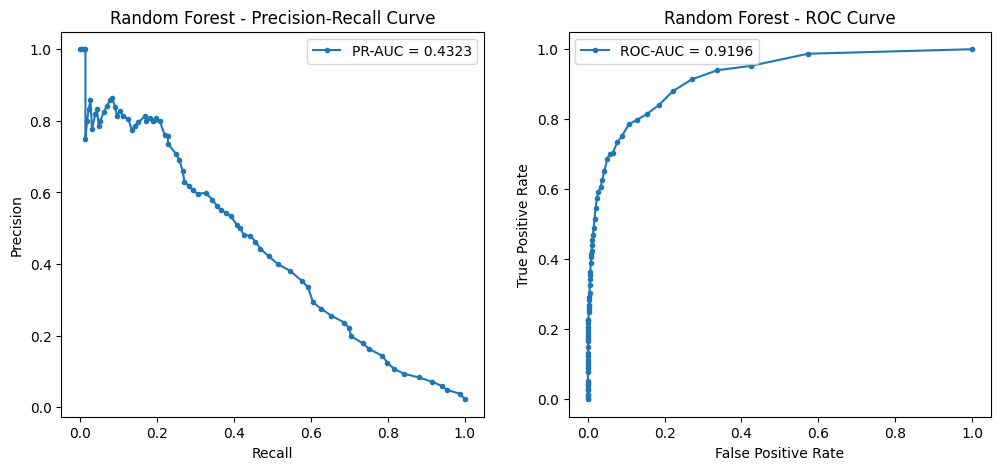

Random Forest training time for node2vec embeddings: 90.79 seconds

===== Training models for deepwalk embeddings =====
Final Feature Matrix Shape: (52158, 136)
Label Distribution: (array([0, 1]), array([50993,  1165]))
Training LightGBM on deepwalk embeddings...
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[deepwalk] Fold 1 - PR-AUC: 0.7192, ROC-AUC: 0.9630, F1-Score: 0.6339, Accuracy: 0.9822
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[deepwalk] Fold 2 - PR-AUC: 0.7132, ROC-AUC: 0.9701, F1-Score: 0.6408, Accuracy: 0.9823
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[deepwalk] Fold 3 - PR-AUC: 0.6730, ROC-AUC: 0.9581, F1-Score: 0.5914, Accuracy: 0.9799
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[deepwalk] Fold 4 - PR-AUC: 0.7226, ROC-AUC: 0.9628, F1-Score: 0.6534, Accuracy: 0.9833
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[deepwalk] Fold 5 - PR-AUC: 0.6730, ROC-AUC: 0.9636, F1-Score: 0.6012, Accuracy: 0.9805

[deepwalk] Final 5-Fold Metrics:
Precision: 0.5751 ± 0.0245
Recall:    0.6824 ± 0.0235
F1-Score:  0.6241 ± 0.0238
Accuracy:  0.9816 ± 0.0013
PR-AUC:    0.7002 ± 0.0224
ROC-AUC:   0.9635 ± 0.0038


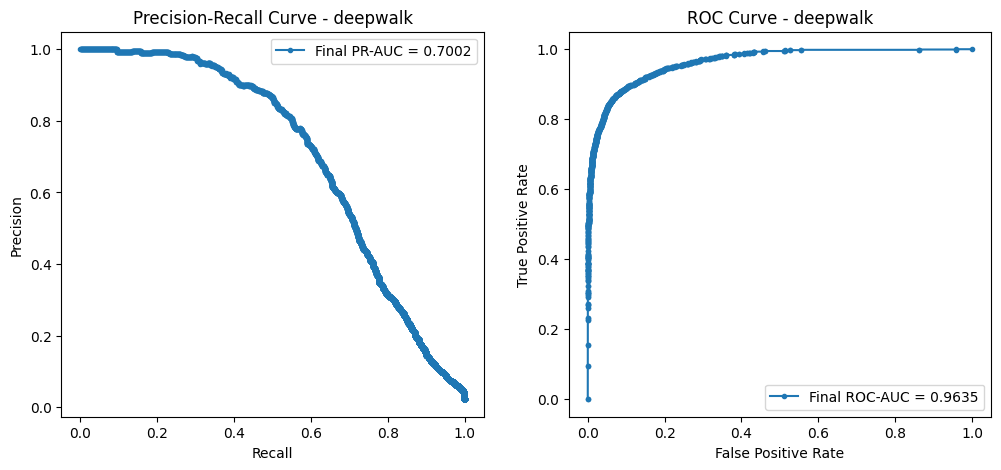

LightGBM training time for deepwalk embeddings: 26.18 seconds
Training XGBoost on deepwalk embeddings...


/home/jovyan/.mlspace/envs/dgl_exp/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:56:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Test Set Evaluation - XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10199
           1       0.55      0.67      0.61       233

    accuracy                           0.98     10432
   macro avg       0.77      0.83      0.80     10432
weighted avg       0.98      0.98      0.98     10432

Additional Metrics:
  Binary - Precision: 0.5532, Recall: 0.6695, F1-Score: 0.6058
  Overall (Macro) - Precision: 0.7728, Recall: 0.8286, F1-Score: 0.7979, Accuracy: 0.9805
  PR-AUC: 0.6689, ROC-AUC: 0.9488



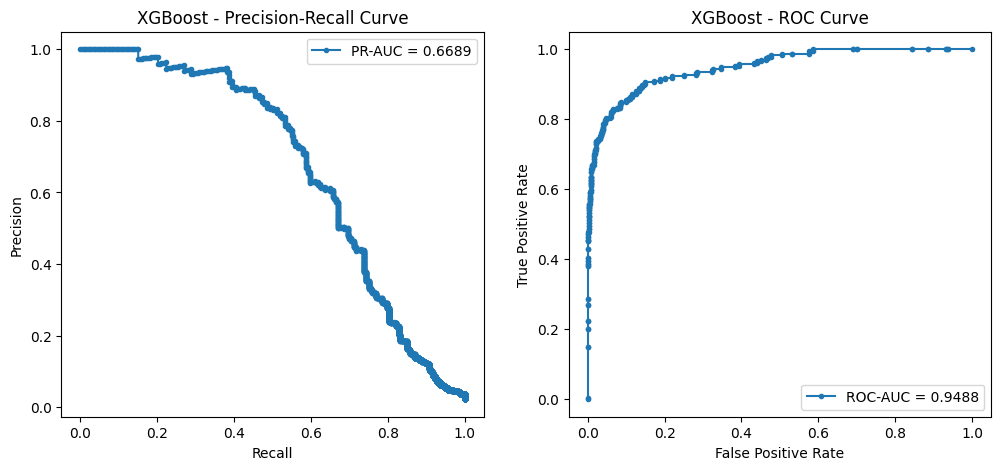

XGBoost training time for deepwalk embeddings: 0.64 seconds
Training Random Forest on deepwalk embeddings...
Final Test Set Evaluation - Random Forest:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10199
           1       1.00      0.00      0.01       233

    accuracy                           0.98     10432
   macro avg       0.99      0.50      0.50     10432
weighted avg       0.98      0.98      0.97     10432

Additional Metrics:
  Binary - Precision: 1.0000, Recall: 0.0043, F1-Score: 0.0085
  Overall (Macro) - Precision: 0.9889, Recall: 0.5021, F1-Score: 0.4987, Accuracy: 0.9778
  PR-AUC: 0.4675, ROC-AUC: 0.9134



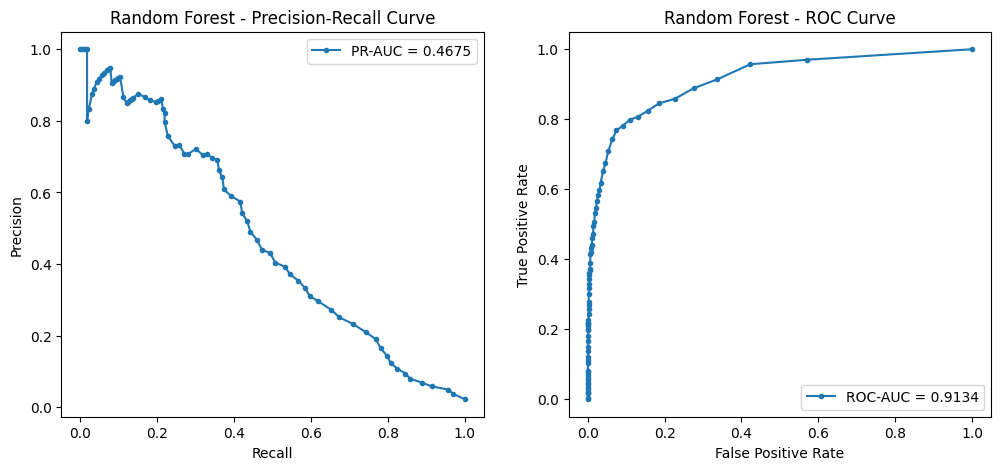

Random Forest training time for deepwalk embeddings: 92.03 seconds

===== Training models for hope embeddings =====
Final Feature Matrix Shape: (52158, 136)
Label Distribution: (array([0, 1]), array([50993,  1165]))
Training LightGBM on hope embeddings...
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[hope] Fold 1 - PR-AUC: 0.7801, ROC-AUC: 0.9765, F1-Score: 0.5842, Accuracy: 0.9733
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[hope] Fold 2 - PR-AUC: 0.7904, ROC-AUC: 0.9689, F1-Score: 0.6035, Accuracy: 0.9763
[LightGBM] [Info] Number of positive: 932, number of negative: 40794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41726, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778957
[LightGBM] [Info] Start training from score -3.778957


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[hope] Fold 3 - PR-AUC: 0.7229, ROC-AUC: 0.9652, F1-Score: 0.5839, Accuracy: 0.9762
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[hope] Fold 4 - PR-AUC: 0.7922, ROC-AUC: 0.9679, F1-Score: 0.5740, Accuracy: 0.9733
[LightGBM] [Info] Number of positive: 932, number of negative: 40795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34680
[LightGBM] [Info] Number of data points in the train set: 41727, number of used features: 136
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022336 -> initscore=-3.778982
[LightGBM] [Info] Start training from score -3.778982


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[hope] Fold 5 - PR-AUC: 0.7606, ROC-AUC: 0.9722, F1-Score: 0.6070, Accuracy: 0.9764

[hope] Final 5-Fold Metrics:
Precision: 0.4676 ± 0.0173
Recall:    0.8034 ± 0.0310
F1-Score:  0.5905 ± 0.0126
Accuracy:  0.9751 ± 0.0015
PR-AUC:    0.7692 ± 0.0257
ROC-AUC:   0.9702 ± 0.0039


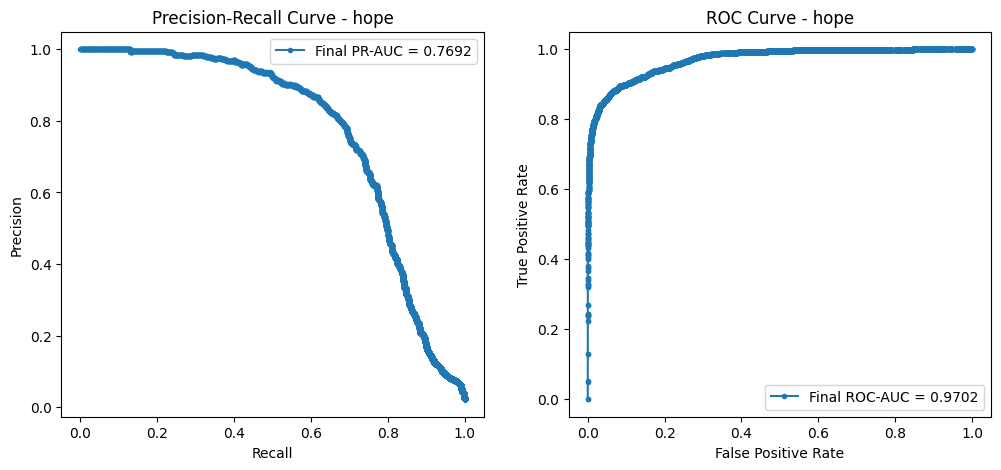

LightGBM training time for hope embeddings: 25.57 seconds
Training XGBoost on hope embeddings...


/home/jovyan/.mlspace/envs/dgl_exp/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:58:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Test Set Evaluation - XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10199
           1       0.46      0.79      0.59       233

    accuracy                           0.97     10432
   macro avg       0.73      0.89      0.79     10432
weighted avg       0.98      0.97      0.98     10432

Additional Metrics:
  Binary - Precision: 0.4648, Recall: 0.7940, F1-Score: 0.5864
  Overall (Macro) - Precision: 0.7300, Recall: 0.8866, F1-Score: 0.7867, Accuracy: 0.9750
  PR-AUC: 0.7432, ROC-AUC: 0.9673



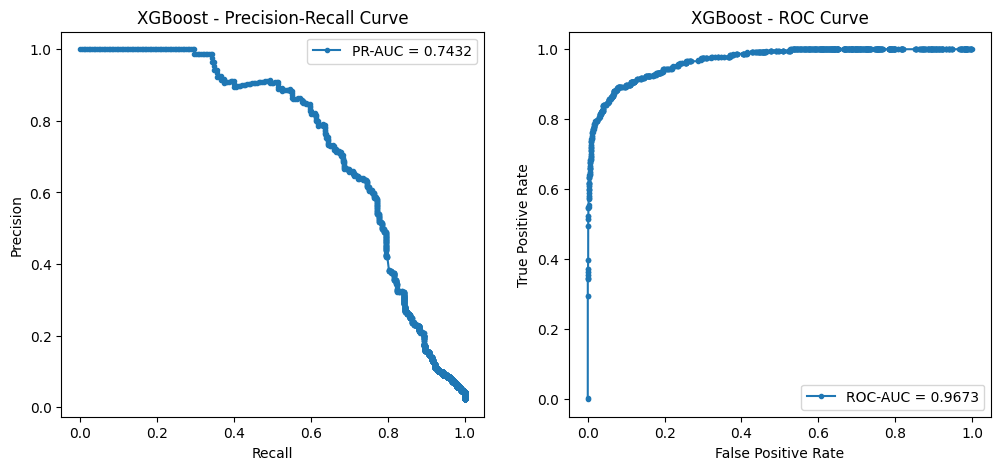

XGBoost training time for hope embeddings: 0.61 seconds
Training Random Forest on hope embeddings...
Final Test Set Evaluation - Random Forest:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10199
           1       0.80      0.45      0.58       233

    accuracy                           0.99     10432
   macro avg       0.90      0.73      0.79     10432
weighted avg       0.98      0.99      0.98     10432

Additional Metrics:
  Binary - Precision: 0.8030, Recall: 0.4549, F1-Score: 0.5808
  Overall (Macro) - Precision: 0.8954, Recall: 0.7262, F1-Score: 0.7867, Accuracy: 0.9853
  PR-AUC: 0.6269, ROC-AUC: 0.9367



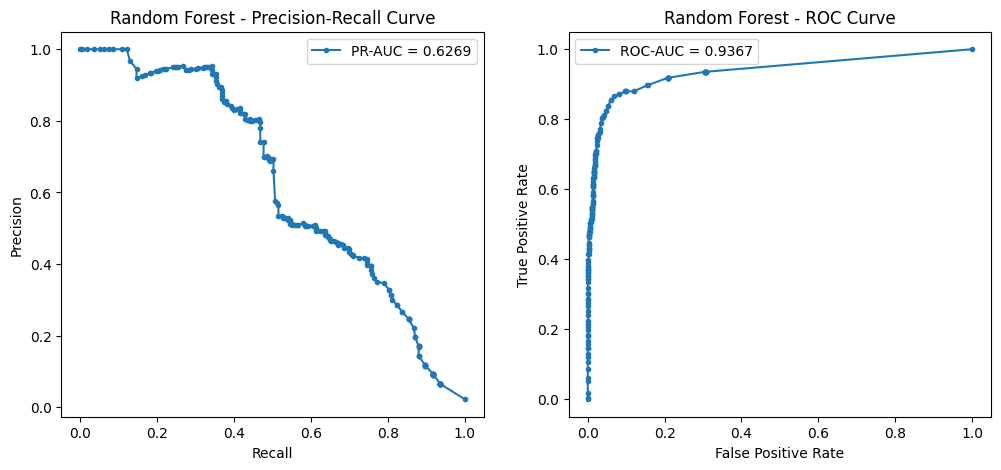

Random Forest training time for hope embeddings: 45.01 seconds


In [22]:
import time

embeddings_dict = {
    "gcn": gcn_embeddings,
    "gat": gat_embeddings,
    "graphsage": graphsage_embeddings,
    "vgae": vgae_embeddings,
    "node2vec": node2vec_embeddings,
    "deepwalk": deepwalk_embeddings,
    "hope": hope_embeddings
}

for name, embedding in embeddings_dict.items():
    print(f"\n===== Training models for {name} embeddings =====")
    
    # Convert PyTorch tensor to NumPy, if needed
    if isinstance(embedding, np.ndarray):
        embedding_np = embedding  # Already a NumPy array
    else:
        embedding_np = embedding.cpu().detach().numpy()  # Convert PyTorch tensor to NumPy
    
    # Concatenate with original features
    X_final = np.concatenate([data.x.cpu().detach().numpy(), embedding_np], axis=1)
    y_final = data.y.cpu().numpy()

    print("Final Feature Matrix Shape:", X_final.shape)  # e.g., (30857, feature_dim + 128)
    print("Label Distribution:", np.unique(y_final, return_counts=True))

    # Train LightGBM and time it
    print(f"Training LightGBM on {name} embeddings...")
    start_time = time.time()
    train_lightgbm(X_final, y_final, name)
    elapsed = time.time() - start_time
    print(f"LightGBM training time for {name} embeddings: {elapsed:.2f} seconds")
    
    # Train XGBoost and time it
    print(f"Training XGBoost on {name} embeddings...")
    start_time = time.time()
    train_xgboost(X_final, y_final)
    elapsed = time.time() - start_time
    print(f"XGBoost training time for {name} embeddings: {elapsed:.2f} seconds")

    # Train Random Forest and time it
    print(f"Training Random Forest on {name} embeddings...")
    start_time = time.time()
    train_random_forest(X_final, y_final)
    elapsed = time.time() - start_time
    print(f"Random Forest training time for {name} embeddings: {elapsed:.2f} seconds")

    # Uncomment below to train SVM as well
    # print(f"Training SVM on {name} embeddings...")
    # start_time = time.time()
    # train_svm(X_final, y_final)
    # elapsed = time.time() - start_time
    # print(f"SVM training time for {name} embeddings: {elapsed:.2f} seconds")